In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.linear_model import LinearRegression
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from keras.callbacks import ModelCheckpoint
from keras.losses import mse, binary_crossentropy
import tensorflow as tf 
from termcolor import colored

In [53]:
def myloss(y_true, y_pred, alpha = 0.1, beta = 0):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  beta*mse(y_true[:,0],y_pred[:,1]) \
                - alpha*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,0])) \
                - alpha*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,0]))
    return myoutput

In [54]:
num_iterations = 1
identity = 0
neg_identity = 0
other = 0
error = 0.05
mu = 1
yintercepts = []

for j in range(num_iterations):
    print("In j = ", j)
    x = mydata = np.random.normal(mu, 1, 10000)
    
    
    


    #setup the model

    myinput = Input(shape=(1,));
    encoded = myinput
    
    #encoded = Dense(5, activation='elu')(myinput);
    #encoded = Dense(5, activation='elu')(encoded);
    encoded = Dense(1, activation='linear')(encoded);

    encoder = Model(myinput, encoded);
    encoder2 = encoder(encoder(myinput));
    autoencoder = Model(myinput, encoder2);

    combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]));

    myinput_classify = Input(shape=(1,));
    myclassifier = Dense(128, activation='elu')(myinput_classify);
    myclassifier = Dense(64, activation='elu')(myclassifier);
    myclassifier = Dense(1, activation='sigmoid')(myclassifier);
    myclassifier_model = Model(myinput_classify, myclassifier);
    myclassifier_input = myclassifier_model(myinput);
    myclassifier_encoded = myclassifier_model(encoded);

    combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]));

    #First, pretrain the autoencoder:
    #autoencoder.compile(optimizer='adam', loss='mse')
    #autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

    preds = [];
    preds += [encoder.predict(np.linspace(-4,4,10))];

    for i in range(20):
        #Now, train the classifier
        encoded_x = encoder.predict(x)[:,0];
        myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy');
        myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=1, batch_size=int(0.01*len(x)));

        #y_scores = encoder.predict(np.concatenate([x,encoded_x]))
        #print(i,roc_auc_score(np.concatenate([np.ones(len(x)),np.zeros(len(x))]),y_scores))

        #Now, update the autoencoder
        for layer in myclassifier_model.layers[:]:
            layer.trainable = False;

        combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred));
        combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=1, batch_size=int(0.01*len(x)));

        preds += [encoder.predict(np.linspace(-4,4,10))];

        for layer in myclassifier_model.layers[:]:
            layer.trainable = True;


    #for i in range(len(preds)):
     #   plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))
      #  pass
    #plt.legend(frameon=False)


    mypreds = combinedModel_classifier.predict(x);

    model = LinearRegression().fit(x.reshape((-1, 1)), mypreds[:,0]);
    #r_sq = model.score(x.reshape((-1, 1)), mypreds[:,0])
    #print('coefficient of determination:', r_sq)
    yintercepts.append(round(model.intercept_, 2));
    #print('slope:', model.coef_)
    
    if abs(model.coef_ - 1) <= error:
        identity += 1
    elif abs(model.coef_ + 1) <= error:
        neg_identity += 1
    else:
        other += 1

In j =  0
100/100 [==============================] - 0s 1ms/step - loss: -1.5372


In [55]:
print("identity = ", identity)
print("neg_identity = ", neg_identity)
print("other = ", other)
print("y_intercepts = ", yintercepts)

identity =  0
neg_identity =  0
other =  1
y_intercepts =  [1.99]


In [56]:
myinput = Input(shape=(1,))

encoded = myinput    
#encoded = Dense(5, activation='elu')(myinput);
#encoded = Dense(5, activation='elu')(encoded);
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)
encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)


encoder.summary()


Model: "functional_761"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_156 (InputLayer)       [(None, 1)]               0         
_________________________________________________________________
dense_425 (Dense)            (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


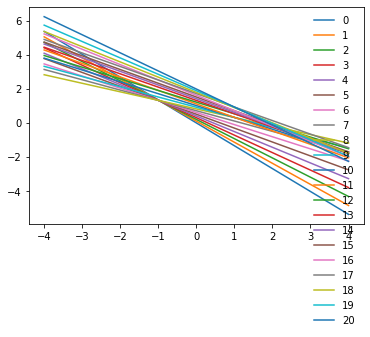

In [57]:
for i in range(len(preds)):
    plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))
    pass
plt.legend(frameon=False)


In [58]:
print(model.coef_)
print(model.intercept_)

[-1.05996132]
1.9857150340114003
